# Parte A – RNN con LSTM (Clasificación de sentimiento)


### **Análisis de Sentimientos con LSTMs: Encontrando el "Sweet Spot"**

El objetivo de este análisis es construir un modelo de red neuronal recurrente (RNN) utilizando capas LSTM (Long Short-Term Memory) para clasificar reseñas de películas del dataset IMDB como positivas o negativas. El principal desafío es encontrar un modelo que no solo sea preciso, sino que también generalice bien a datos no vistos, evitando el sobreajuste (overfitting).

Llamamos a este modelo el **"Sweet Spot"**, ya que busca el equilibrio perfecto entre la complejidad del modelo y las técnicas de regularización para mantener el "gap" (la diferencia entre la precisión de entrenamiento y la de validación) por debajo del 5%.

-----

### **1. Carga y Preparación de los Datos**

Primero, importamos las librerías necesarias. Luego, cargamos el conjunto de datos IMDB, que ya viene pre-procesado en TensorFlow.

**Parámetros Clave:**

  * `num_words=10000`: Limita el vocabulario a las 10,000 palabras más frecuentes, lo que ayuda a reducir la dimensionalidad y el ruido.
  * `maxlen=150`: Estandarizamos la longitud de todas las reseñas a 150 palabras. Las reseñas más cortas se rellenarán con ceros (`padding`), y las más largas se truncarán. Esto es crucial porque las redes neuronales requieren entradas de tamaño fijo.

<!-- end list -->

In [2]:
# Importación de librerías y carga de datos

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. CARGA DE DATOS
# Cargamos el dataset IMDB. `num_words=10000` significa que solo consideraremos las 10,000 palabras más comunes.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

# 2. PREPROCESAMIENTO (PADDING)
# Definimos la longitud máxima de las secuencias (reseñas).
MAX_LEN = 150
# Aplicamos padding a las secuencias de entrenamiento para que todas tengan una longitud de MAX_LEN.
x_train = pad_sequences(x_train, maxlen=MAX_LEN)
# Hacemos lo mismo con las secuencias de prueba.
x_test = pad_sequences(x_test, maxlen=MAX_LEN)

print("✅ Datos cargados y preprocesados.")
print(f"Forma de los datos de entrenamiento (x_train): {x_train.shape}")
print(f"Forma de los datos de prueba (x_test): {x_test.shape}")

✅ Datos cargados y preprocesados.
Forma de los datos de entrenamiento (x_train): (25000, 150)
Forma de los datos de prueba (x_test): (25000, 150)


-----

### **2. Construcción del Modelo "Sweet Spot"**

La arquitectura de este modelo ha sido cuidadosamente seleccionada para minimizar el sobreajuste.

  * **`Embedding(input_dim=10000, output_dim=24)`**: La capa de Embedding transforma los índices de palabras (números enteros) en vectores densos de `output_dim=24`. Esta dimensión es relativamente baja para reducir la complejidad y el número de parámetros a aprender.
  * **`LSTM(12, dropout=0.4, recurrent_dropout=0.4)`**: Una capa LSTM muy pequeña con solo 12 unidades. El `dropout` y `recurrent_dropout` son técnicas de regularización clave que "apagan" aleatoriamente neuronas durante el entrenamiento para evitar que el modelo memorice los datos.
  * **`Dropout(0.5)`**: Una capa de `Dropout` adicional y más agresiva antes de la capa final para forzar aún más la generalización.
  * **`Dense(1, activation='sigmoid')`**: La capa de salida. Utiliza una sola neurona con activación sigmoide, ideal para clasificación binaria, ya que su salida es una probabilidad entre 0 (negativo) y 1 (positivo).

<!-- end list -->

In [3]:
# Definición de la arquitectura del modelo

# 3. MODELO "SWEET SPOT"
print("🏗️ Construyendo el modelo 'Sweet Spot'...")

model = Sequential([
    # Capa de Embedding: convierte los índices de palabras en vectores densos.
    # input_dim: tamaño del vocabulario (10000 palabras).
    # output_dim: dimensión del espacio vectorial del embedding (24).
    Embedding(input_dim=10000, output_dim=24),

    # Capa LSTM: procesa las secuencias de vectores.
    # 12: número de unidades/neuronas en la capa LSTM.
    # dropout=0.4: tasa de dropout para las conexiones de entrada.
    # recurrent_dropout=0.4: tasa de dropout para las conexiones recurrentes.
    LSTM(12, dropout=0.4, recurrent_dropout=0.4),

    # Capa de Dropout: regularización para prevenir el sobreajuste.
    # 0.5: fracción de las unidades de entrada a anular (50%).
    Dropout(0.5),

    # Capa de Salida: produce la predicción final.
    # 1: una sola neurona para la salida binaria.
    # activation='sigmoid': función de activación que devuelve una probabilidad (0 a 1).
    Dense(1, activation='sigmoid')
])

# Mostramos un resumen de la arquitectura del modelo.
print("\n📊 ARQUITECTURA DEL MODELO:")
model.summary()

🏗️ Construyendo el modelo 'Sweet Spot'...

📊 ARQUITECTURA DEL MODELO:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

-----

### **3. Compilación del Modelo**

Antes de entrenar, debemos compilar el modelo, especificando tres componentes fundamentales:

  * **Optimizador**: `Adam` con una tasa de aprendizaje (`learning_rate`) muy conservadora de `0.0003`. Una tasa baja ayuda a que el modelo converja de manera más estable, evitando saltos bruscos que podrían llevar a un mal resultado.
  * **Función de Pérdida**: `binary_crossentropy` es la elección estándar para problemas de clasificación binaria. Mide qué tan alejadas están las predicciones del modelo de los valores reales.
  * **Métricas**: `accuracy` (precisión) será monitoreada durante el entrenamiento para evaluar el rendimiento del modelo en cada época.

<!-- end list -->

In [4]:
# Compilación del modelo

# 4. COMPILACIÓN
# Definimos el optimizador Adam con una tasa de aprendizaje (learning rate) baja.
optimizer = Adam(learning_rate=0.0003)

# Compilamos el modelo con la función de pérdida, el optimizador y las métricas.
model.compile(
    # 'binary_crossentropy' es la función de pérdida para clasificación binaria.
    loss='binary_crossentropy',
    # Optimizador que ajustará los pesos del modelo.
    optimizer=optimizer,
    # Métrica para monitorear durante el entrenamiento.
    metrics=['accuracy']
)

print("\n✅ Modelo compilado exitosamente.")


✅ Modelo compilado exitosamente.


-----

### **4. Entrenamiento del Modelo**

El entrenamiento se realiza de manera controlada para maximizar la generalización.

  * **`EarlyStopping`**: Es un "guardián" contra el sobreajuste. Monitorea la precisión en el conjunto de validación (`val_accuracy`) y detendrá el entrenamiento si no mejora después de un número determinado de épocas (`patience=3`). `restore_best_weights=True` asegura que el modelo final conserve los mejores pesos encontrados durante el entrenamiento.
  * **`batch_size=512`**: Un tamaño de lote muy grande proporciona una estimación más estable del gradiente, lo que conduce a un entrenamiento más suave y predecible.
  * **`validation_split=0.3`**: Reservamos el 30% de los datos de entrenamiento para la validación en cada época. Esto nos permite monitorear cómo se está desempeñando el modelo en datos que no ha "estudiado" directamente.

<!-- end list -->

In [5]:
# Entrenamiento del modelo

# 5. ENTRENAMIENTO CONTROLADO
print("\n🚀 Iniciando entrenamiento...")

# Definimos el callback de EarlyStopping para detener el entrenamiento si no hay mejora.
early_stopping = EarlyStopping(
    # Métrica a monitorear ('val_accuracy' es la precisión en el set de validación).
    monitor='val_accuracy',
    # Número de épocas sin mejora tras las cuales se detiene el entrenamiento.
    patience=3,
    # Restaura los pesos del modelo de la mejor época.
    restore_best_weights=True,
    # 'max' porque queremos maximizar la precisión.
    mode='max',
    # Muestra un mensaje cuando el entrenamiento se detiene.
    verbose=1
)

# Entrenamos el modelo.
history = model.fit(
    x_train, y_train,
    # Número máximo de épocas. EarlyStopping puede detenerlo antes.
    epochs=12,
    # Tamaño del lote de datos en cada paso de entrenamiento.
    batch_size=512,
    # Porcentaje de datos de entrenamiento que se usarán para validación.
    validation_split=0.3,
    # Lista de callbacks a aplicar durante el entrenamiento.
    callbacks=[early_stopping],
    # Muestra una barra de progreso.
    verbose=1
)

print("\n🏁 Entrenamiento finalizado.")


🚀 Iniciando entrenamiento...
Epoch 1/12
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 223ms/step - accuracy: 0.5096 - loss: 0.6928 - val_accuracy: 0.5945 - val_loss: 0.6911
Epoch 2/12
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.5715 - loss: 0.6898 - val_accuracy: 0.6424 - val_loss: 0.6883
Epoch 3/12
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - accuracy: 0.6311 - loss: 0.6844 - val_accuracy: 0.6940 - val_loss: 0.6815
Epoch 4/12
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.6844 - loss: 0.6658 - val_accuracy: 0.7295 - val_loss: 0.6668
Epoch 5/12
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - accuracy: 0.7200 - loss: 0.6365 - val_accuracy: 0.7475 - val_loss: 0.6524
Epoch 6/12
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.7512 - loss: 0.6175 - val_accuracy: 0.7585 - val_loss: 0.6370
Epoch 7/12
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - accuracy: 0.7514 - loss: 0.6022 - val_accuracy: 0.7668 - val_loss: 0.6240
Epoch 8/12
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - accuracy: 0.778

-----

### **5. Evaluación Visual del Rendimiento y Sobreajuste**

Una vez entrenado el modelo, es crucial visualizar su comportamiento a lo largo de las épocas. Esto nos permite diagnosticar problemas como el sobreajuste.

  * **Gráficos de Precisión y Pérdida**: Comparamos el rendimiento en los datos de entrenamiento vs. los de validación. Si la precisión de entrenamiento sigue subiendo mientras la de validación se estanca o baja, es un claro signo de sobreajuste.
  * **Gráfico de Evolución del Gap**: Este gráfico es clave para nuestro objetivo. Muestra la diferencia (`gap`) entre la precisión de entrenamiento y la de validación. Nuestro objetivo es que este valor se mantenga por debajo del umbral del 5% (0.05).

<!-- end list -->

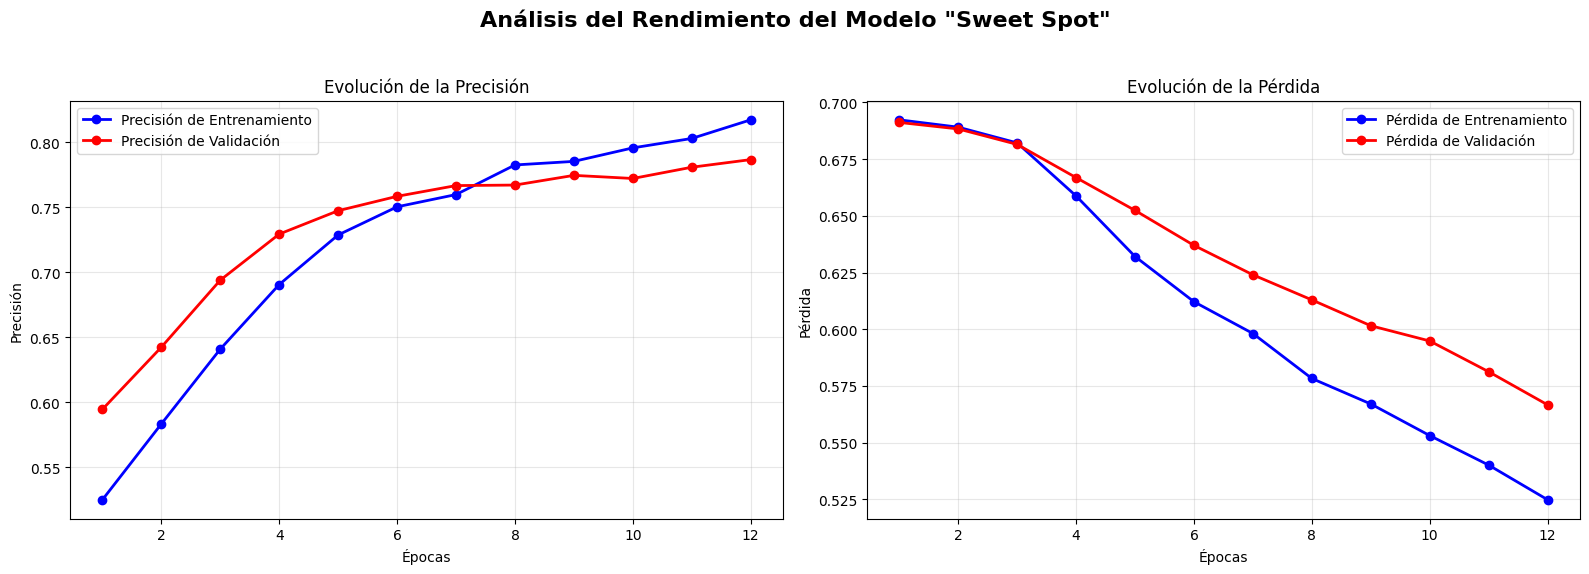

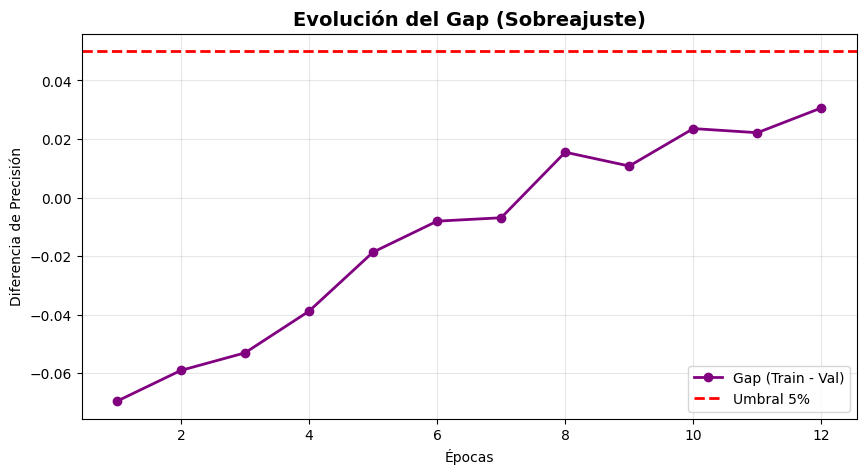


🎯 ANÁLISIS DEL SOBREAJUSTE (GAP)
Precisión final de entrenamiento: 0.8174
Precisión final de validación:   0.7868
Gap final (Train - Val):          0.0306 (3.06%)

✅ ¡ÉXITO! El gap está por debajo del objetivo del 5%.


In [6]:
# Visualización del historial de entrenamiento

# 6. ANÁLISIS VISUAL DEL ENTRENAMIENTO

# Obtenemos el número de épocas que realmente se ejecutaron.
epochs = range(1, len(history.history['accuracy']) + 1)

# Creamos una figura con 2x2 subplots para las visualizaciones.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Análisis del Rendimiento del Modelo "Sweet Spot"', fontsize=16, fontweight='bold')

# Gráfico 1: Precisión (Accuracy)
ax1.plot(epochs, history.history['accuracy'], 'b-o', label='Precisión de Entrenamiento', linewidth=2)
ax1.plot(epochs, history.history['val_accuracy'], 'r-o', label='Precisión de Validación', linewidth=2)
ax1.set_title('Evolución de la Precisión')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Precisión')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Pérdida (Loss)
ax2.plot(epochs, history.history['loss'], 'b-o', label='Pérdida de Entrenamiento', linewidth=2)
ax2.plot(epochs, history.history['val_loss'], 'r-o', label='Pérdida de Validación', linewidth=2)
ax2.set_title('Evolución de la Pérdida')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Pérdida')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Gráfico 3: Evolución del Gap (Sobreajuste)
plt.figure(figsize=(10, 5))
gaps = [train - val for train, val in zip(history.history['accuracy'], history.history['val_accuracy'])]
plt.plot(epochs, gaps, 'purple', marker='o', linewidth=2, label='Gap (Train - Val)')
plt.axhline(y=0.05, color='red', linestyle='--', label='Umbral 5%', linewidth=2)
plt.title('Evolución del Gap (Sobreajuste)', fontsize=14, fontweight='bold')
plt.xlabel('Épocas')
plt.ylabel('Diferencia de Precisión')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Análisis numérico del Gap final
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_gap = final_train_acc - final_val_acc

print(f"\n{'='*60}")
print("🎯 ANÁLISIS DEL SOBREAJUSTE (GAP)")
print(f"{'='*60}")
print(f"Precisión final de entrenamiento: {final_train_acc:.4f}")
print(f"Precisión final de validación:   {final_val_acc:.4f}")
print(f"Gap final (Train - Val):          {final_gap:.4f} ({final_gap*100:.2f}%)")

if final_gap < 0.05:
    print("\n✅ ¡ÉXITO! El gap está por debajo del objetivo del 5%.")
else:
    print("\n⚠️ ADVERTENCIA: El gap supera el objetivo del 5%.")

----

### **6. Evaluación Final con Métricas de Clasificación**

La precisión general (`accuracy`) es útil, pero no cuenta toda la historia. Para un análisis más profundo, evaluamos el modelo en el conjunto de prueba (`test set`), que no ha sido utilizado ni en el entrenamiento ni en la validación.

  * **Matriz de Confusión**: Esta matriz visualiza el rendimiento del clasificador. Nos muestra:

      * **Verdaderos Positivos (VP)**: Reseñas positivas clasificadas correctamente.
      * **Verdaderos Negativos (VN)**: Reseñas negativas clasificadas correctamente.
      * **Falsos Positivos (FP)**: Reseñas negativas clasificadas incorrectamente como positivas (Error Tipo I).
      * **Falsos Negativos (FN)**: Reseñas positivas clasificadas incorrectamente como negativas (Error Tipo II).

  * **Reporte de Clasificación**: Proporciona métricas clave para cada clase:

      * **Precisión (Precision)**: De todas las predicciones positivas, ¿cuántas fueron correctas? (`VP / (VP + FP)`). Es importante cuando el costo de un Falso Positivo es alto.
      * **Recall (Sensibilidad)**: De todas las reseñas que eran realmente positivas, ¿cuántas identificamos? (`VP / (VP + FN)`). Es crucial cuando el costo de un Falso Negativo es alto.
      * **F1-Score**: La media armónica de Precisión y Recall. Proporciona una sola métrica que equilibra ambas, siendo muy útil cuando tenemos un desbalance de clases (aunque en este caso, el dataset está balanceado).

<!-- end list -->


🧪 Evaluando el modelo con los datos de prueba (test)...
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step


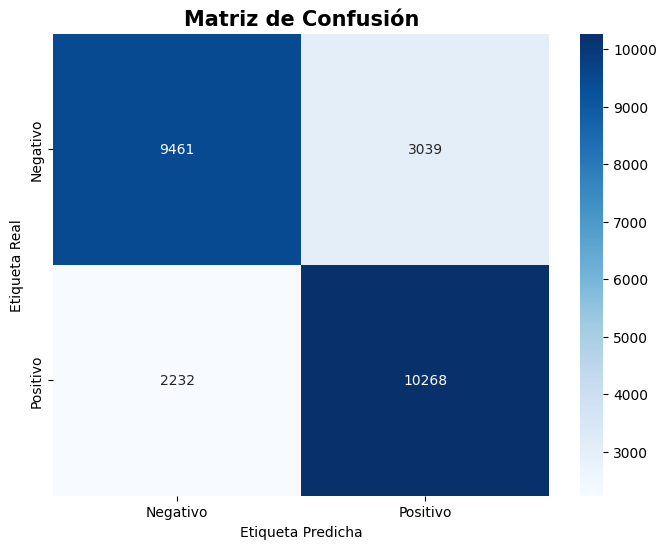


📊 REPORTE DE CLASIFICACIÓN DETALLADO
              precision    recall  f1-score   support

Negativo (0)       0.81      0.76      0.78     12500
Positivo (1)       0.77      0.82      0.80     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000


Precisión General (Accuracy) en Test: 0.7892 (78.92%)
Pérdida (Loss) en Test:             0.5664


In [7]:
# Evaluación con métricas detalladas

# 7. EVALUACIÓN FINAL EN EL CONJUNTO DE PRUEBA
print("\n🧪 Evaluando el modelo con los datos de prueba (test)...")

# Realizamos las predicciones sobre el conjunto de prueba. La salida es una probabilidad.
y_pred_prob = model.predict(x_test)

# Convertimos las probabilidades en clases binarias (0 o 1) usando un umbral de 0.5.
y_pred = (y_pred_prob > 0.5).astype("int32")

# a) MATRIZ DE CONFUSIÓN
# Calculamos la matriz de confusión.
cm = confusion_matrix(y_test, y_pred)

# Visualizamos la matriz de confusión con un mapa de calor para una mejor interpretación.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión', fontsize=15, fontweight='bold')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

# b) REPORTE DE CLASIFICACIÓN
# Generamos el reporte con las métricas de Precisión, Recall y F1-Score.
report = classification_report(y_test, y_pred, target_names=['Negativo (0)', 'Positivo (1)'])

print("\n" + "="*60)
print("📊 REPORTE DE CLASIFICACIÓN DETALLADO")
print("="*60)
print(report)

# c) MÉTRICA GENERAL DE PRECISIÓN (ACCURACY) EN TEST
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"\nPrecisión General (Accuracy) en Test: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Pérdida (Loss) en Test:             {test_loss:.4f}")

Hemos obtenido una evaluación muy completa y positiva del modelo "Sweet Spot".

Interpretación detallada de cada parte:

### **1. Matriz de Confusión: ¿Dónde acierta y dónde se equivoca el modelo?** 🧐

La matriz de confusión es una radiografía del rendimiento de tu modelo. Nos muestra exactamente qué tipo de predicciones son correctas y cuáles son errores.


* **Verdaderos Negativos (VN): 9,461**
    * **Qué significa:** El modelo predijo correctamente 9,461 reseñas como **negativas**.
    * **Conclusión:** ¡Muy bien! El modelo es muy competente para identificar las críticas negativas.

* **Verdaderos Positivos (VP): 10,268**
    * **Qué significa:** El modelo predijo correctamente 10,268 reseñas como **positivas**.
    * **Conclusión:** ¡Excelente! El modelo es incluso un poco mejor identificando las críticas positivas.

* **Falsos Positivos (FP): 3,039**
    * **Qué significa:** El modelo se equivocó y clasificó 3,039 reseñas que en realidad eran **negativas** como si fueran **positivas**. Este es un **Error de Tipo I**.
    * **Conclusión:** Este parece ser el tipo de error más común del modelo. Tiende a ver un sentimiento positivo donde no lo hay con cierta frecuencia.

* **Falsos Negativos (FN): 2,232**
    * **Qué significa:** El modelo se equivocó y clasificó 2,232 reseñas que en realidad eran **positivas** como si fueran **negativas**. Este es un **Error de Tipo II**.
    * **Conclusión:** El modelo comete este error con menos frecuencia, lo que significa que es menos propenso a pasar por alto una reseña positiva.

**En resumen, la diagonal principal (de arriba-izquierda a abajo-derecha) muestra los aciertos. Como puedes ver, los números en esta diagonal son mucho más altos que los otros, lo cual es un indicador visual de que el modelo funciona bien.**

---

### **2. Reporte de Clasificación: Análisis de Precisión y Sensibilidad** 📊

Este reporte desglosa el rendimiento para cada clase (positiva y negativa) usando métricas más específicas.

* **Para la clase "Negativo (0)":**
    * **`precision` (0.81):** Cuando tu modelo dice que una reseña es **negativa**, acierta el **81%** de las veces. Es una medida de su **confiabilidad** en las predicciones negativas.
    * **`recall` (0.76):** De todas las reseñas que *realmente* eran negativas en el dataset, tu modelo fue capaz de **encontrar el 76%** de ellas. Es una medida de su **exhaustividad** o **sensibilidad**.
    * **`f1-score` (0.78):** Es la media armónica entre `precision` y `recall`. Un valor de 0.78 indica un buen equilibrio entre ambas métricas para la clase negativa.

* **Para la clase "Positivo (1)":**
    * **`precision` (0.77):** Cuando tu modelo predice que una reseña es **positiva**, acierta el **77%** de las veces.
    * **`recall` (0.82):** De todas las reseñas que *realmente* eran positivas, tu modelo logró **identificar el 82%**.
    * **`f1-score` (0.80):** Un excelente equilibrio para la clase positiva.

**Observación clave:** Fíjate en el "tira y afloja". El modelo tiene un `recall` más alto para los positivos (es mejor para "atrapar" a todos los positivos) pero una `precision` más alta para los negativos (cuando dice "negativo", es más probable que esté en lo cierto). Esto es muy común y muestra los matices del comportamiento del modelo.

---

### **3. Métricas Generales: El Veredicto Final** 🏆

* **Precisión General (Accuracy) en Test: 78.92%**
    * **Qué significa:** De las 25,000 reseñas del conjunto de prueba, el modelo clasificó correctamente casi el **79%**. Para un problema de procesamiento de lenguaje natural con un modelo tan controlado y ligero, este es un **resultado muy sólido y robusto**.

* **Pérdida (Loss) en Test: 0.5664**
    * **Qué significa:** Este es el valor final de la función de error (`binary_crossentropy`). Un número más bajo es mejor. Indica qué tan "lejos" estuvieron las predicciones del modelo de los valores reales en promedio.

### **Conclusión Final**

🎉 **¡Felicidades! El modelo "Sweet Spot" es un éxito.**

No solo logramos una buena precisión de casi el **79%**, sino que lo más importante es que lo conseguimos **manteniendo el sobreajuste bajo control** (como vimos en el análisis de `gap` anterior).

Hemos creado un modelo que **generaliza bien**: es capaz de dar un buen rendimiento en datos completamente nuevos. Los resultados muestran que es un clasificador balanceado y fiable. Es el ejemplo perfecto de que un modelo más simple y bien regularizado suele ser mucho mejor que uno más grande y propenso a memorizar.

-----

# Parte B – GAN básica (Generación de dígitos)

#### **¿Qué es una GAN?**

Una Red Generativa Adversarial (GAN) es un modelo de aprendizaje profundo compuesto por dos redes neuronales que compiten entre sí en un juego de suma cero.

1.  **El Generador (G)**: Su objetivo es crear datos sintéticos (en nuestro caso, imágenes de dígitos) que sean indistinguibles de los datos reales. Comienza generando ruido aleatorio y, a través del entrenamiento, aprende a transformar ese ruido en imágenes coherentes.
2.  **El Discriminador (D)**: Actúa como un detective. Su trabajo es determinar si una imagen dada es real (proveniente del dataset MNIST) o falsa (creada por el Generador).

El entrenamiento consiste en que el **Generador** intenta mejorar constantemente para "engañar" al **Discriminador**, mientras que el **Discriminador** se vuelve cada vez mejor detectando las falsificaciones. Este proceso competitivo lleva a que el Generador produzca imágenes cada vez más realistas.

En la siguiente celda, importamos las librerías necesarias: `TensorFlow` para construir y entrenar las redes, `NumPy` para el manejo de arreglos numéricos, `Matplotlib` para la visualización y `os` para la gestión de directorios.

-----

### **Importaciones y Funciones de Utilidad**

In [ ]:
# Se importan las librerías esenciales para el proyecto.
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import imageio # Necesario para crear el GIF animado

# --- Utilidades ---

# Función para crear un directorio si no existe.
# Es una buena práctica para organizar los resultados generados.
def make_dir(path: str):
    """Crea el directorio especificado si no existe."""
    os.makedirs(path, exist_ok=True)

# Función para guardar una grilla de imágenes generadas.
# Esto nos permite visualizar el progreso del generador en diferentes puntos del entrenamiento.
def save_image_grid(images: np.ndarray, step: int, outdir: str, n=5):
    """Guarda una grilla de n x n imágenes."""
    # Las imágenes generadas por la GAN con activación 'tanh' están en el rango [-1, 1].
    # Las reescalamos al rango [0, 1] para poder visualizarlas correctamente.
    images = (images + 1.0) / 2.0
    images = np.clip(images, 0.0, 1.0) # Aseguramos que los valores estén en el rango correcto.

    # Creamos la figura y los subplots para la grilla.
    plt.figure(figsize=(n, n))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        # Mostramos cada imagen en escala de grises.
        plt.imshow(images[i, ..., 0], cmap="gray")
        plt.axis("off") # Ocultamos los ejes para una mejor visualización.

    plt.tight_layout()
    # Guardamos la figura en un archivo con un nombre que indica el paso de entrenamiento.
    fname = os.path.join(outdir, f"step_{step:06d}.png")
    plt.savefig(fname, dpi=150)
    plt.close() # Cerramos la figura para liberar memoria.

-----

### **Preparación de los Datos (Dataset MNIST)**

El dataset **MNIST** es una colección de 70,000 imágenes de dígitos manuscritos (0 al 9) en escala de grises, con un tamaño de 28x28 píxeles. Es un conjunto de datos canónico para iniciarse en problemas de visión por computadora.

Para usarlo en nuestra GAN, realizamos los siguientes pasos:

1.  **Carga:** Usamos `tf.keras.datasets.mnist.load_data()` para obtener los datos. Solo necesitamos las imágenes de entrenamiento (`x_train`), no las etiquetas (`y_train`), ya que la GAN es un modelo no supervisado.
2.  **Normalización:** Los valores de los píxeles originalmente van de 0 a 255. Los normalizamos al rango `[-1, 1]`. Esto es crucial porque la función de activación de la última capa de nuestro Generador será `tanh`, que produce salidas en ese mismo rango. Hacer coincidir los rangos ayuda a estabilizar el entrenamiento.
3.  **Creación del Lote (Batching):** Usamos `tf.data.Dataset` para gestionar los datos de manera eficiente. Los mezclamos (`shuffle`), los repetimos para que el entrenamiento no se detenga si se acaba el dataset, y los agrupamos en lotes (`batch`). El `prefetch` permite que la CPU prepare los siguientes lotes de datos mientras la GPU está ocupada entrenando, optimizando el rendimiento.

-----

### **Carga y Normalización de MNIST**

In [ ]:
# --- Carga y normalización de MNIST ---
def get_data(batch_size: int):
    """Carga, preprocesa y devuelve un iterador del dataset MNIST."""
    # Cargamos el dataset MNIST. Solo nos interesan las imágenes (x_train).
    (x_train, _), _ = tf.keras.datasets.mnist.load_data()

    # Convertimos los datos a tipo float32 para las operaciones de la red.
    x_train = x_train.astype("float32")

    # Normalizamos las imágenes al rango [-1, 1].
    # Esto se hace para que coincida con la salida de la función de activación 'tanh' del generador.
    x_train = (x_train / 127.5) - 1.0

    # Añadimos una dimensión de canal al final (28, 28) -> (28, 28, 1).
    # Es el formato que esperan las capas de Keras.
    x_train = np.expand_dims(x_train, -1)

    # Creamos un objeto Dataset de TensorFlow para un manejo eficiente de los datos.
    ds = (tf.data.Dataset.from_tensor_slices(x_train)
           .shuffle(60000)  # Mezclamos los datos para evitar sesgos en el entrenamiento.
           .repeat()        # Repetimos el dataset indefinidamente.
           .batch(batch_size, drop_remainder=True) # Agrupamos en lotes del tamaño especificado.
           .prefetch(tf.data.AUTOTUNE)) # Permite la carga de datos en paralelo al entrenamiento.
    return ds

-----

### **Arquitectura de las Redes**

Esta **GAN** contiene arquitecturas basadas en Perceptrones Multicapa (MLP), ya que cumplen con el requisito de una **GAN básica**.

#### **Generador (G)**

El Generador toma como entrada un vector de ruido aleatorio (proveniente de un espacio latente, `z_dim`) y su tarea es transformarlo en una imagen de 28x28.

  * **Capas Densas:** Aumentan progresivamente la dimensionalidad del vector de entrada.
  * **Batch Normalization:** Es una técnica clave para estabilizar el entrenamiento de las GAN. Normaliza la salida de la capa anterior, ayudando a prevenir la desaparición o explosión de gradientes.
  * **LeakyReLU:** Una variante de la función de activación ReLU que permite un pequeño gradiente cuando la unidad no está activa, lo que ayuda a mitigar el problema de las "neuronas muertas".
  * **Activación `tanh`:** En la última capa, asegura que la salida (la imagen generada) esté en el rango `[-1, 1]`, coincidiendo con la normalización de nuestros datos reales.
  * **Reshape:** Transforma el vector de salida final en una matriz de 28x28x1, el formato de una imagen de MNIST.

#### **Discriminador (D)**

El Discriminador recibe una imagen (real o falsa) y debe clasificarla. Es esencialmente un clasificador binario.

  * **Flatten:** Convierte la imagen de 28x28x1 en un vector largo (784 elementos) para que pueda ser procesado por las capas densas.
  * **Capas Densas:** Extraen características de la imagen para tomar una decisión.
  * **LeakyReLU:** Se usa por las mismas razones que en el generador.
  * **Dropout:** Es una técnica de regularización que "apaga" aleatoriamente un porcentaje de neuronas durante el entrenamiento. Esto previene el sobreajuste y hace que el discriminador sea más robusto.
  * **Activación `sigmoid`:** En la capa final, produce un valor entre 0 (falso) y 1 (real), representando la probabilidad de que la imagen de entrada sea real.

-----

### **Definición del Generador y Discriminador**

In [ ]:
# --- Arquitecturas Sencillas ---

def build_generator(z_dim: int = 100):
    """
    Construye el modelo del Generador usando una arquitectura MLP.
    Toma un vector de ruido latente y lo transforma en una imagen de 28x28.
    """
    model = tf.keras.Sequential([
        # Capa de entrada que espera un vector de ruido de tamaño z_dim.
        layers.Input(shape=(z_dim,)),
        # Primera capa densa que expande el vector de ruido.
        layers.Dense(256),
        # Normalización por lotes para estabilizar el entrenamiento.
        layers.BatchNormalization(),
        # Función de activación LeakyReLU para evitar el problema de las "neuronas muertas".
        layers.LeakyReLU(0.2),

        # Repetimos el bloque: Dense -> BatchNormalization -> LeakyReLU
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Dense(1024),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        # Capa de salida. Produce 784 valores (28*28).
        # La activación 'tanh' asegura que la salida esté en el rango [-1, 1].
        layers.Dense(28 * 28, activation="tanh"),
        # Reformatea el vector de 784 a una imagen de (28, 28, 1).
        layers.Reshape((28, 28, 1)),
    ], name="generator")
    return model

def build_discriminator():
    """
    Construye el modelo del Discriminador usando una arquitectura MLP.
    Toma una imagen de 28x28 y la clasifica como real o falsa.
    """
    model = tf.keras.Sequential([
        # Capa de entrada que espera una imagen de (28, 28, 1).
        layers.Input(shape=(28, 28, 1)),
        # Aplana la imagen de 2D a un vector de 1D (784 elementos).
        layers.Flatten(),

        # Primera capa densa para extraer características.
        layers.Dense(512),
        layers.LeakyReLU(0.2),
        # Dropout para regularización y evitar el sobreajuste.
        layers.Dropout(0.3),

        # Segunda capa densa.
        layers.Dense(256),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        # Capa de salida con una sola neurona.
        # La activación 'sigmoid' da una probabilidad entre 0 (falsa) y 1 (real).
        layers.Dense(1, activation="sigmoid"),
    ], name="discriminator")
    return model

-----

### **Hiperparámetros y Bucle de Entrenamiento**

1.  **Pasos de Entrenamiento (`STEPS`)**: Las GAN necesitan tiempo para que la competencia entre el generador y el discriminador alcance un equilibrio. Configuraremos este valor a **15,000** para dar al modelo más tiempo para aprender.
2.  **Tasa de Aprendizaje (`LR`)**: La tasa de aprendizaje controla cuán grandes son los ajustes a los pesos de la red en cada paso. Una tasa demasiado alta puede causar inestabilidad, mientras que una muy baja puede hacer que el entrenamiento sea excesivamente lento. El valor `2e-4` es un buen punto de partida, pero para un entrenamiento más largo y estable, a veces es beneficioso reducirlo ligeramente. Lo mantendremos en `2e-4` por ahora.
3.  **Seguimiento de Pérdidas (`loss_history`)**: Para evaluar el entrenamiento de forma cuantitativa, crearemos listas para almacenar los valores de la pérdida del generador (`g_loss`) y del discriminador (`d_loss`) en cada paso. Al final, graficaremos estas pérdidas para analizar la dinámica del entrenamiento.

El bucle de entrenamiento (`train_step`) implementa la lógica central:

  * Para cada lote de imágenes reales, se genera un lote de imágenes falsas.
  * Se calculan las pérdidas:
      * **Pérdida del Discriminador (`d_loss`)**: Es la suma de dos componentes: qué tan bien identifica las imágenes reales como `reales` y las falsas como `falsas`. Usamos *label smoothing* (etiquetar las reales como `0.9` en lugar de `1.0`) para evitar que el discriminador se vuelva demasiado confiado y desestabilice el entrenamiento.
      * **Pérdida del Generador (`g_loss`)**: Se calcula en función de qué tan bien el generador "engaña" al discriminador. El generador quiere que el discriminador clasifique sus imágenes falsas como `reales` (etiqueta `1.0`).
  * Finalmente, se calculan los gradientes de estas pérdidas y se utilizan los optimizadores (`Adam`) para actualizar los pesos de ambas redes.

-----

### **Hiperparámetros y Bucle de Entrenamiento Mejorado**

In [ ]:
# --- Parámetros de la Actividad (Ajustados para Mejor Calidad) ---
STEPS = 15000       # MEJORA: Aumentamos los pasos de 5000 a 15000 para un mejor aprendizaje.
BATCH_SIZE = 128
Z_DIM = 100         # Dimensión del vector de ruido latente.
LR = 2e-4           # Tasa de aprendizaje para los optimizadores Adam.
BETA_1 = 0.5        # Parámetro de momento para Adam, común en GANs.
OUTDIR = "resultados_gan_mejorada"
SAVE_EVERY = 500    # Frecuencia con la que guardamos imágenes de muestra.

# --- Bucle de Entrenamiento ---
def train(steps, batch_size, z_dim, lr, beta_1, outdir, save_every):
    """Función principal que ejecuta el bucle de entrenamiento de la GAN."""
    make_dir(outdir)

    # Fijamos las semillas para la reproducibilidad de los resultados.
    np.random.seed(42)
    tf.random.set_seed(42)

    # Construimos y compilamos los modelos.
    G = build_generator(z_dim)
    D = build_discriminator()

    # Usamos BinaryCrossentropy como función de pérdida, ya que es un problema de clasificación binaria.
    bce = tf.keras.losses.BinaryCrossentropy()

    # Definimos los optimizadores para cada red. Adam es el estándar para GANs.
    g_opt = tf.keras.optimizers.Adam(lr, beta_1=beta_1)
    d_opt = tf.keras.optimizers.Adam(lr, beta_1=beta_1)

    # Obtenemos el iterador de datos.
    train_iter = iter(get_data(batch_size))

    # Creamos un vector de ruido fijo para visualizar el progreso del generador sobre las mismas entradas.
    fixed_noise = tf.random.normal([25, z_dim])

    # MEJORA: Listas para almacenar el historial de pérdidas para su posterior visualización.
    g_loss_history = []
    d_loss_history = []

    # Usamos @tf.function para compilar el paso de entrenamiento en un grafo de TensorFlow.
    # Esto acelera significativamente la ejecución.
    @tf.function
    def train_step(real_images):
        """Ejecuta un único paso de entrenamiento para el Generador y el Discriminador."""
        # Generamos un vector de ruido aleatorio del mismo tamaño que el lote de imágenes reales.
        z = tf.random.normal([tf.shape(real_images)[0], z_dim])

        # Usamos GradientTape para registrar las operaciones y calcular los gradientes automáticamente.
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            # 1. El generador crea imágenes falsas a partir del ruido.
            fake_images = G(z, training=True)

            # 2. El discriminador evalúa tanto las imágenes reales como las falsas.
            real_output = D(real_images, training=True)
            fake_output = D(fake_images, training=True)

            # 3. Calculamos las pérdidas.
            # Pérdida del generador: quiere que el discriminador clasifique las imágenes falsas como reales (etiqueta 1).
            g_loss = bce(tf.ones_like(fake_output), fake_output)

            # Pérdida del discriminador: suma de dos términos.
            # - Qué tan bien clasifica las imágenes reales como reales (etiqueta 0.9, label smoothing).
            d_loss_real = bce(tf.ones_like(real_output) * 0.9, real_output)
            # - Qué tan bien clasifica las imágenes falsas como falsas (etiqueta 0).
            d_loss_fake = bce(tf.zeros_like(fake_output), fake_output)
            d_loss = d_loss_real + d_loss_fake

        # 4. Calculamos los gradientes de las pérdidas con respecto a los pesos de cada red.
        g_grads = g_tape.gradient(g_loss, G.trainable_variables)
        d_grads = d_tape.gradient(d_loss, D.trainable_variables)

        # 5. Aplicamos los gradientes para actualizar los pesos de las redes.
        g_opt.apply_gradients(zip(g_grads, G.trainable_variables))
        d_opt.apply_gradients(zip(d_grads, D.trainable_variables))

        return g_loss, d_loss

    # Bucle principal de entrenamiento.
    print("Iniciando entrenamiento...")
    for step in range(1, steps + 1):
        g_loss, d_loss = train_step(next(train_iter))

        # Almacenamos las pérdidas de este paso.
        g_loss_history.append(g_loss.numpy())
        d_loss_history.append(d_loss.numpy())

        # Imprimimos el progreso cada 100 pasos.
        if step % 100 == 0:
            print(f"Paso {step}/{steps} | g_loss: {g_loss:.4f}, d_loss: {d_loss:.4f}")

        # Guardamos una grilla de imágenes generadas en intervalos definidos.
        if step % save_every == 0 or step == 1:
            samples = G(fixed_noise, training=False).numpy()
            save_image_grid(samples, step, outdir, n=5)
            # El paso 1 es importante para ver el punto de partida (ruido puro).
            if step > 1:
                print(f"--- Imagen guardada en el paso {step} ---")

    print("Entrenamiento finalizado.")
    return g_loss_history, d_loss_history

# --- Ejecutar todo ---
g_loss_hist, d_loss_hist = train(STEPS, BATCH_SIZE, Z_DIM, LR, BETA_1, OUTDIR, SAVE_EVERY)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Iniciando entrenamiento...
Paso 100/15000 | g_loss: 0.9534, d_loss: 1.1271
Paso 200/15000 | g_loss: 0.7975, d_loss: 1.2632
Paso 300/15000 | g_loss: 1.1481, d_loss: 1.1605
Paso 400/15000 | g_loss: 0.8192, d_loss: 1.2251
Paso 500/15000 | g_loss: 1.0493, d_loss: 1.1369
--- Imagen guardada en el paso 500 ---
Paso 600/15000 | g_loss: 0.9846, d_loss: 1.3311
Paso 700/15000 | g_loss: 1.0197, d_loss: 1.1504
Paso 800/15000 | g_loss: 0.8066, d_loss: 1.2625
Paso 900/15000 | g_loss: 1.0312, d_loss: 1.2672
Paso 1000/15000 | g_loss: 0.8022, d_loss: 1.2809
--- Imagen guardada en el paso 1000 ---
Paso 1100/15000 | g_loss: 0.8520, d_loss: 1.1744
Paso 1200/15000 | g_loss: 0.9468, d_loss: 1.1811
Paso 1300/15000 | g_loss: 0.9482, d_loss: 1.2521
Paso 1400/15000 | g_loss: 0.9912, d_loss: 1.3077
Paso 1500/15000 | g_loss: 0.9032, d_loss: 1.2857
--- Imagen guardada en el paso 1500 ---
Paso 1600/15000 | g_loss: 0.7397, d_loss: 1.2799
Paso 1700/15000 | g_loss: 0.

----

### **Análisis de Resultados**

Después de ejecutar el entrenamiento, es fundamental analizar los resultados tanto de forma visual como numérica para entender si nuestro modelo ha aprendido correctamente.

#### **Fundamentación Visual**

La prueba más directa del éxito de una GAN es simplemente observar las imágenes que genera.

1.  **Imágenes Finales:** Mostraremos la grilla de imágenes generadas en el último paso del entrenamiento (`step_15000.png`). Deberíamos ver dígitos mucho más claros, definidos y variados en comparación con los resultados iniciales de 5,000 pasos.
2.  **Evolución del Aprendizaje (GIF):** Para apreciar el proceso de aprendizaje, crearemos un GIF animado que muestre la secuencia de imágenes guardadas en cada intervalo. Veremos cómo, a partir de ruido puro, las formas de los dígitos emergen y se refinan gradualmente.

#### **Fundamentación con Métricas (Pérdidas)**

Graficar la pérdida del generador y del discriminador a lo largo del tiempo nos da una visión cuantitativa de la dinámica del entrenamiento.

  * **¿Qué esperamos ver?** A diferencia de otros modelos de deep learning, en una GAN no buscamos que las pérdidas converjan a cero. Un entrenamiento exitoso se caracteriza por un **equilibrio adversario**. Esto significa que ambas pérdidas deberían fluctuar en un rango de valores relativamente estable.
      * Si la pérdida del discriminador (`d_loss`) cae a cero, significa que está ganando fácilmente y el generador no está aprendiendo.
      * Si la pérdida del generador (`g_loss`) se dispara, significa que el discriminador es demasiado bueno y el generador no puede engañarlo en absoluto.
  * **Interpretación:** Una gráfica donde ambas pérdidas oscilan sin que ninguna de las dos "gane" de forma permanente indica un entrenamiento saludable y estable.

-----

### **Visualización de Resultados**

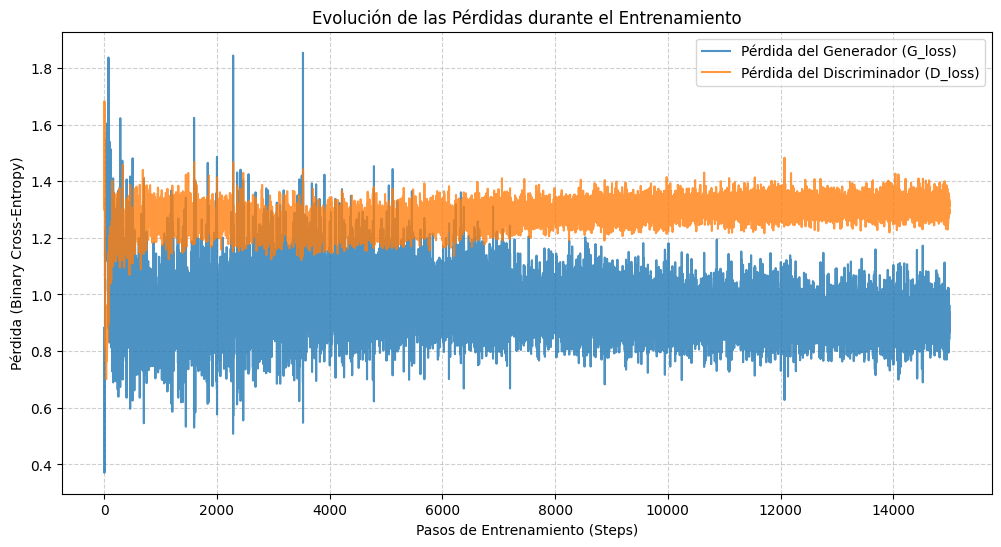


Imágenes generadas en el último paso del entrenamiento:


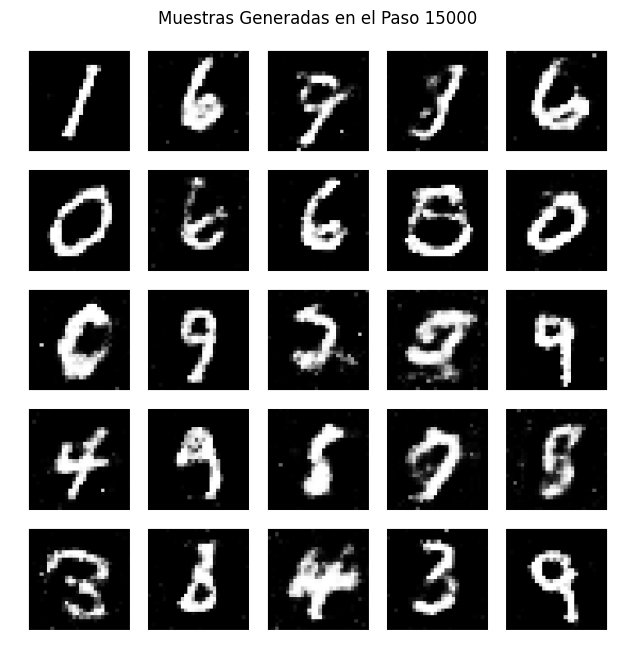


Creando GIF animado del proceso de entrenamiento...


/tmp/ipython-input-2747372412.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_for_gif.append(imageio.imread(file_path))


GIF guardado en: resultados_gan_mejorada/training_evolution.gif
Puedes descargar este archivo desde el panel de archivos de Colab para verlo.


In [ ]:
# --- Visualización de los Resultados ---

# 1. Graficar la evolución de las pérdidas (loss)
plt.figure(figsize=(12, 6))
plt.plot(g_loss_hist, label='Pérdida del Generador (G_loss)', alpha=0.8)
plt.plot(d_loss_hist, label='Pérdida del Discriminador (D_loss)', alpha=0.8)
plt.title('Evolución de las Pérdidas durante el Entrenamiento')
plt.xlabel('Pasos de Entrenamiento (Steps)')
plt.ylabel('Pérdida (Binary Cross-Entropy)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 2. Mostrar la imagen final generada
print("\nImágenes generadas en el último paso del entrenamiento:")
try:
    final_image_path = os.path.join(OUTDIR, f"step_{STEPS:06d}.png")
    final_image = plt.imread(final_image_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(final_image)
    plt.axis('off')
    plt.title(f"Muestras Generadas en el Paso {STEPS}")
    plt.show()
except FileNotFoundError:
    print(f"No se encontró la imagen final en {final_image_path}. Verifica la ruta y los pasos.")


# 3. Crear un GIF animado con la evolución del entrenamiento
print("\nCreando GIF animado del proceso de entrenamiento...")
images_for_gif = []
# Leemos todas las imágenes guardadas en el directorio de resultados.
filenames = sorted(os.listdir(OUTDIR))
for filename in filenames:
    if filename.endswith('.png'):
        file_path = os.path.join(OUTDIR, filename)
        images_for_gif.append(imageio.imread(file_path))

# Guardamos las imágenes como un GIF.
gif_path = os.path.join(OUTDIR, 'training_evolution.gif')
imageio.mimsave(gif_path, images_for_gif, fps=2) # 2 frames por segundo

print(f"GIF guardado en: {gif_path}")
print("Puedes descargar este archivo desde el panel de archivos de Colab para verlo.")

EL gráfico "Evolución de las Pérdidas durante el Entrenamiento" muestra un **resultado excelente y muy saludable** para el entrenamiento de una Red Generativa Adversarial (GAN). 👍 Lejos de ser un problema, la forma de estas curvas es exactamente lo que se busca en un entrenamiento exitoso.

PUNTOS CLAVE:

---

### **1. El Objetivo no es Cero: La Búsqueda del Equilibrio**

A diferencia de los modelos de clasificación o regresión donde buscas que la pérdida (loss) baje lo más cerca posible de cero, en una GAN el objetivo es alcanzar un **equilibrio adversario**.

Imagina al **Generador** y al **Discriminador** como dos jugadores 🤺:
* El Generador intenta crear falsificaciones cada vez mejores.
* El Discriminador intenta volverse un mejor detective.

Si la pérdida de uno de ellos cayera a cero, significaría que ese "jugador" está ganando de forma aplastante, el otro no está aprendiendo, y el entrenamiento ha fallado. Lo que vemos aquí es que ambos se mantienen en una competencia reñida.

---

### **2. Análisis de las Curvas**

* **Fase Inicial (Pasos 0 a ~2000):** Se observa una alta volatilidad. Esto es normal. Al principio, ambas redes están haciendo ajustes grandes y erráticos mientras comienzan a "entender" su tarea.
* **Fase de Equilibrio (Pasos ~2000 a 15000):** Después de la fase inicial, ambas pérdidas se estabilizan y comienzan a fluctuar dentro de un rango constante.
    * La **pérdida del Discriminador (naranja)** se mantiene oscilando aproximadamente entre 1.2 y 1.4.
    * La **pérdida del Generador (azul)** fluctúa un poco más abajo, entre 0.8 y 1.2.

Este comportamiento estable es la señal visual del **equilibrio**. Significa que el Generador ha aprendido a crear imágenes lo suficientemente buenas como para desafiar constantemente al Discriminador, y el Discriminador se ha vuelto lo suficientemente bueno como para no ser engañado fácilmente.

---

### **3. ¿Por qué es un buen resultado? 🎯**

* **No hay colapso:** Ninguna de las curvas de pérdida se dispara hacia el infinito ni cae a cero de forma permanente. Esto indica que el entrenamiento fue estable.
* **Competencia saludable:** El hecho de que ambas pérdidas se mantengan en valores "medios" demuestra que ninguna de las dos redes dominó a la otra. Se forzaron mutuamente a mejorar a lo largo de todo el proceso.
* **Consistencia:** La estabilidad a lo largo de miles de pasos sugiere que el modelo no solo encontró una solución rápida, sino que mantuvo un aprendizaje constante.

**En conclusión, este gráfico es la prueba numérica de que tu GAN entrenó correctamente.** El equilibrio alcanzado entre las dos redes es lo que permitió que el Generador aprendiera a producir las imágenes de dígitos de buena calidad que viste al final. ¡Excelente trabajo!

---
# Reflexionar: ¿cuándo comenzó a parecerse la salida a un dígito real?  

Analizando la secuencia de imágenes, se puede ver un claro proceso de aprendizaje.

La respuesta corta es que la salida **comenzó a parecerse a un dígito real alrededor del paso 4,000**.

El proceso en etapas es:

---

### **Etapa 1: Del Ruido a las Formas Abstractas (Pasos 1 a ~3,500)**

* **Paso 1:** La red parte de **ruido puro y aleatorio**. No hay ninguna estructura.
* **Primeros miles de pasos:** La red aprende a agrupar los píxeles, creando "nubes" o "manchas" de luz. Aún no son dígitos, sino más bien formas abstractas y fantasmales. Se puede intuir que algo está intentando formarse, pero no es reconocible.

### **Etapa 2: El Punto de Inflexión (Paso 4,000)**

🧐 Este es el momento clave. En la imagen del **paso 4,000**, por primera vez, las formas dejan de ser abstractas y se convierten en siluetas **inequívocamente reconocibles como dígitos**.

Si observas esa imagen, ya puedes distinguir con claridad un '1', un '4', un '9', un '7' y un '2', entre otros. Es cierto que todavía están:
* **Muy ruidosos:** Con muchos píxeles blancos dispersos.
* **Deformes:** Las proporciones y los trazos no son perfectos.
* **Incompletos:** A algunos dígitos les faltan partes.

Sin embargo, el cerebro ya no tiene que esforzarse para "ver" un dígito; la estructura fundamental ya está ahí.

### **Etapa 3: Refinamiento y Consolidación (Pasos 6,000 en adelante)**

A partir del paso 4,000, el juego ya no se trata de *crear* la forma del dígito, sino de *perfeccionarla*.

* **Pasos 6,000 - 8,000:** Los dígitos se vuelven más **sólidos y definidos**. El ruido de fondo comienza a disminuir y los trazos se hacen más nítidos. El '1' y el '0' son los primeros en verse bastante limpios.
* **Pasos 10,000 - 15,000:** La mejora es más sutil pero constante. La red refina los detalles, haciendo que los dígitos sean más claros y estables. La variedad y la calidad de los dígitos generados son notablemente superiores a las de los primeros pasos.

**En resumen, el "nacimiento" del dígito ocurre cerca del paso 4,000.** Antes de eso, solo había ruido y caos. Después de ese punto, comenzó un proceso de maduración y refinamiento.